# Initializing setup

In [1]:
import os
import time
import uuid
import cv2

import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

import albumentations as alb

d:\Python\Python312\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [23]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

# Collecting images

In [11]:
TRAIN_PATH = os.path.join('real_data','train','images')
TEST_PATH = os.path.join('real_data','test','images')
VAL_PATH = os.path.join('real_data','val','images')

### Training data

In [18]:
train_num = 60

cap = cv2.VideoCapture(0)
for num in range(train_num):
    ret, frame = cap.read()
    print(f'Collecting image {num}: {ret}')
    image_name = os.path.join(TRAIN_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(image_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Test data

In [19]:
test_num = 20

cap = cv2.VideoCapture(0)
for num in range(test_num):
    ret, frame = cap.read()
    print(f'Collecting image {num}: {ret}')
    image_name = os.path.join(TEST_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(image_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Validation data

In [20]:
val_num = 50

cap = cv2.VideoCapture(0)
for num in range(val_num):
    ret, frame = cap.read()
    print(f'Collecting image {num}: {ret}')
    image_name = os.path.join(VAL_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(image_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Creating labels

In [21]:
!labelme

2024-09-15 18:18:16,977 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\DELL\.labelmerc
2024-09-15T13:20:05.592ZE [20992:ShellIpcClient] ipc_socket_win.cc:162:Connect CreateFile on pipe failed: 
2024-09-15T13:20:05.593ZE [20992:ShellIpcClient] ipc_socket_win.cc:163:static cello::fs::IpcSocket::Connect 231: All pipe instances are busy.




# Viewing data

In [2]:
random_image = cv2.cvtColor(cv2.imread('real_data/train/images/4aa22d35-7358-11ef-b59c-50eb71bdd737.jpg'), cv2.COLOR_BGR2RGB)
with open(os.path.join('real_data/train/labels/4aa22d35-7358-11ef-b59c-50eb71bdd737.json'), 'r') as f:
    random_label = json.load(f)

random_label['shapes']

[{'label': 'LeftEye',
  'points': [[309.72222222222223, 256.11111111111114]],
  'group_id': None,
  'description': '',
  'shape_type': 'point',
  'flags': {},
  'mask': None},
 {'label': 'RightEye',
  'points': [[408.61111111111114, 252.77777777777777]],
  'group_id': None,
  'description': '',
  'shape_type': 'point',
  'flags': {},
  'mask': None}]

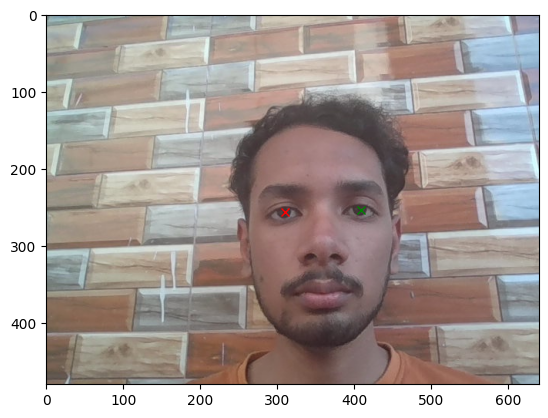

In [3]:
plt.imshow(random_image)
plt.plot(random_label['shapes'][0]['points'][0][0], random_label['shapes'][0]['points'][0][1], 'rx')
plt.plot(random_label['shapes'][1]['points'][0][0], random_label['shapes'][1]['points'][0][1], 'gx')

# Augmenting data

In [4]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [75]:
def assign_labels(label, classes, coords, position):
    if label['shapes'][position]['label'] == 'LeftEye':
        classes[0] = 1
        coords[0] = label['shapes'][position]['points'][0][0]
        coords[1] = label['shapes'][position]['points'][0][1]

    if label['shapes'][position]['label'] == 'RightEye':
        classes[1] = 1
        coords[2] = label['shapes'][position]['points'][0][0]
        coords[3] = label['shapes'][position]['points'][0][1]

    return classes, coords

for folder in ['train','test','val']:
    for image_name in os.listdir(os.path.join('real_data', folder, 'images')):
        classes = [0,0]
        coords = [0,0,0.00001,0.00001]

        image_path = os.path.join('real_data', folder, 'images', image_name)
        label_path = os.path.join('real_data', folder, 'labels', f'{image_name.split('.')[0]}.json')
        img = cv2.imread(image_path)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f: label = json.load(f)

            classes, coords = assign_labels(label, classes, coords, 0)

            if len(label['shapes']) == 2:
                classes, coords = assign_labels(label, classes, coords, 1)
            
            #print(label['shapes'][0]['label'], label['shapes'][0]['points'][0], end=' ')
            #if len(label['shapes']) == 2: print(label['shapes'][1]['label'], label['shapes'][1]['points'][0])
            #else: print()
            #print(classes, coords, '\n')

            np.divide(coords, [640,480, 640, 480])

        try:
            for x in range(120):
                augmented = augmentor(image = img, keypoints = [coords[:2], coords[2:]], class_labels = ['LeftEye','RightEye'])
                augmented_image_path = os.path.join('aug_data', folder, 'images', f'{image_name.split('.')[0]}.{x}.jpg')
                augmented_label_path = os.path.join('aug_data', folder, 'labels', f'{image_name.split('.')[0]}.{x}.json')

                #cv2.imwrite(augmented_image_path, augmented['image'])
                annotation = {}
                annotation['image'] = image_path
                annotation['class'] = [0, 0]
                annotation['coords'] = [0, 0, 0, 0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0:
                        print(augmented['class_labels'], augmented['keypoints'])
                        break

        except Exception as e:
            print(e)

['LeftEye', 'RightEye'] [(249, 221), (154, 220)]
['LeftEye', 'RightEye'] [(235, 239), (136, 235)]
['LeftEye', 'RightEye'] [(438, 192), (312, 188)]
['RightEye'] [(60, 239)]
['RightEye'] [(98, 212)]
['RightEye'] [(397, 211)]
['RightEye'] [(413, 247)]
['RightEye'] [(78, 234)]
['LeftEye', 'RightEye'] [(334, 157), (109, 150)]
['RightEye'] [(291, 257)]
['RightEye'] [(45, 274)]
['RightEye'] [(36, 315)]
['LeftEye'] [(20, 264)]
['LeftEye', 'RightEye'] [(160, 193), (53, 188)]
['LeftEye', 'RightEye'] [(173, 224), (276, 222)]
['LeftEye', 'RightEye'] [(227, 211), (122, 204)]
['RightEye'] [(181, 205)]
['RightEye'] [(148, 208)]
['RightEye'] [(246, 225)]
['LeftEye'] [(240, 150)]
['LeftEye'] [(144, 158)]
['LeftEye'] [(180, 291)]
['LeftEye', 'RightEye'] [(253, 229), (154, 240)]
['LeftEye'] [(199, 185)]
['LeftEye', 'RightEye'] [(68, 151), (362, 140)]
['LeftEye', 'RightEye'] [(224, 251), (427, 260)]
['LeftEye'] [(198, 234)]
['LeftEye'] [(332, 214)]
['LeftEye'] [(241, 214)]
['LeftEye'] [(330, 99)]
['LeftEy